In [4]:
import sys 
sys.path += ["../src"]
import BC_leaders, BC_update
import numpy as np
from tqdm import tqdm
from time import time
import pickle
from glob import glob
from pyABC_ import pyabc
from scipy.special import expit as np_sigmoid

import os
from tempfile import gettempdir
from pyABC_.pyabc.sampler import SingleCoreSampler
from jax.scipy.special import expit as sigmoid
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from numpyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS
from numpyro.infer.autoguide import AutoNormal, AutoBNAFNormal, AutoIAFNormal
from numpyro import distributions
import numpyro
from numpyro.optim import Adam
import jax.random as random
from datetime import timedelta
# numpyro.set_platform("gpu")
from diptest import dipstat
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt

In [5]:
from importlib import reload
reload(BC_update)

<module 'BC_update' from '/home/jacopo.lenti/LOTM/notebooks/../src/BC_update.py'>

In [6]:
#### new update ####

def compute_X_from_X0_params(X0, edges_iter, mu_plus, mu_minus, is_backfire = True):
    # edges_iter = (edges_t for edges_t in edges)
    # Xt = jax.lax.stop_gradient(X0.copy())
    Xt = X0.copy()
    X_list = [Xt.copy()]
    
    N = len(Xt)
    
    while True:
        edges_t = next(edges_iter, None)
        if edges_t is None:
            break
        
        u,v,s_plus,s_minus = edges_t.T
        u,v = u.astype(int),v.astype(int)
        diff_X = Xt[u] - Xt[v]

        updates_plus = mu_plus * s_plus * diff_X
        updates_minus = (mu_minus * s_minus * diff_X) * is_backfire
        # print(updates_minus)
        # Xt = Xt.at[v].add(updates_plus - updates_minus).clip(1e-5, 1 - 1e-5)
        Xt[v] += updates_plus - updates_minus
        Xt[v] = np.clip(Xt[v], 1e-5, 1 - 1e-5)
        
        X_list.append(Xt.copy())

    return jnp.stack(X_list)


In [7]:
# def initialize_training(X, edges, rho = 32):
#     T, N = X.shape    
#     edges_iter = (edges_t for edges_t in edges)
#     u,v,s_plus,s_minus,t = BC_leaders.convert_edges_uvst(edges)
#     s_plus, s_minus = jnp.float32(s_plus), jnp.float32(s_minus)

#     # X0 = np.array(X[0])
#     X0 = jnp.array(X[0].copy())
#     return {"u": u, "v": v, "s_plus": s_plus, "s_minus": s_minus, "t": t,
#             "N": N, "T": T, "rho": rho, "X0": X0,# "edges":edges
#             "edges_iter": edges_iter
#             }

def initialize_training(X, edges, mu_plus, mu_minus, rho = 32):
    T, N = X.shape    
    u,v,s_plus,s_minus,t = BC_leaders.convert_edges_uvst(edges)
    s_plus, s_minus = jnp.float32(s_plus), jnp.float32(s_minus)

    X0 = np.array(X[0])
    edges_iter = (edge for edge in edges)
    X_bc = compute_X_from_X0_params(X0, edges_iter, mu_plus, mu_minus, is_backfire = False)
    edges_iter = (edge for edge in edges)
    X_back = compute_X_from_X0_params(X0, edges_iter, mu_plus, mu_minus, is_backfire = True)
    u,v,t = u.astype(int), v.astype(int), t.astype(int)

    diff_X_bc = X_bc[t,u] - X_bc[t,v]
    diff_X_back = X_back[t,u] - X_back[t,v]

    return {"u": u, "v": v, "s_plus": s_plus, "s_minus": s_minus, "t": t,
            "N": N, "T": T, "rho": rho,
            "diff_X_bc": diff_X_bc, "diff_X_back": diff_X_back}



In [8]:
def model(data):
    dim = 3
    dist = distributions.Normal(jnp.zeros(dim), jnp.ones(dim)).to_event(1)
    params = numpyro.sample("theta", dist)
    
    theta = params[:2]
    param_backfire = params[2:]
    epsilon_plus, epsilon_minus = sigmoid(theta) /  2 + jnp.array([0.,.5])

    ############
    diff_X_bc,diff_X_back,u,v,s_plus, s_minus,t, rho, N, T = [data[k] for k in ["diff_X_bc", "diff_X_back","u","v",
                                                                      "s_plus", "s_minus","t",
                                                                      "rho", "N", "T"]]
    
    
    backfire_sample = numpyro.sample("backfire", distributions.RelaxedBernoulli(probs = param_backfire, temperature = jnp.array([0.1])).to_event(1))
    is_backfire = backfire_sample[0]
        
    s_plus = jnp.array(s_plus)
    s_minus = jnp.array(s_minus)
 
    diff_X = (1 - is_backfire) * diff_X_bc + is_backfire * diff_X_back
    kappas_plus = BC_leaders.kappa_plus_from_epsilon(epsilon_plus, diff_X, rho, with_jax = True)
    kappas_minus = BC_leaders.kappa_minus_from_epsilon(epsilon_minus, diff_X, rho, with_jax = True)
    kappas_ = jnp.concatenate([kappas_minus, kappas_plus])
    s = jnp.concatenate([s_minus, s_plus])

    with numpyro.plate("data", s.shape[0]):
        numpyro.sample("obs", distributions.Bernoulli(probs = kappas_), obs = s)



In [9]:
def train_mcmc(X, edges, mu_plus, mu_minus, intermediate_samples = None, rho = 32, num_chains = 1,
               warmup_samples = None, n_samples = 400, progress_bar = False, id = None, timeout = 3600):
    if intermediate_samples is None:
        intermediate_samples = n_samples
    if warmup_samples is None:
        warmup_samples = intermediate_samples

    initialize_training(jnp.array(X), jnp.array(edges), mu_plus, mu_minus, rho = rho)
    key = random.PRNGKey(0)
    mcmc = MCMC(NUTS(model), num_warmup = warmup_samples, num_chains = num_chains, 
                num_samples = intermediate_samples, progress_bar = progress_bar)
    res = []
    tot_time = 0
    for _ in range(int(n_samples / intermediate_samples)):
        t0 = time()
        mcmc.run(key, data)
        t1 = time()
        tot_time += t1 - t0

        mcmc.post_warmup_state = mcmc.last_state
        key = mcmc.post_warmup_state.rng_key
        
        mcmc_samples = mcmc.get_samples()
        param_mean, param_std, backfire_prob = analyse_samples(mcmc_samples)
        res.append({"param_mean": param_mean,
                    "param_std": param_std,
                    "backfire_prob": backfire_prob,
                    "tot_time": tot_time,
                    "n_simulations": None,
                    "method": "mcmc",
                    "n_steps": None,
                    "n_samples": intermediate_samples * (_ + 1),
                    "id": id})
        if tot_time > timeout:
            break

    return res



In [10]:
def train_svi(X, edges, mu_plus, mu_minus, guide_family = "normal", rho = 32,
              n_steps = 4000, intermediate_steps = None, lr = 0.01, 
              progress_bar = False, id = None, timeout = 3600):
    if intermediate_steps is None:
        intermediate_steps = n_steps
    
    if guide_family == "normal":
        guide = AutoNormal(model)
    if guide_family == "NF":
        guide = AutoBNAFNormal(model, num_flows = 1, hidden_factors = (8,8))
        n_steps = int(n_steps / 2)
        intermediate_steps = int(intermediate_steps / 2)
    
    data = initialize_training(jnp.array(X), jnp.array(edges), mu_plus, mu_minus, rho = rho)
    optimizer = Adam(step_size = lr)
    svi = SVI(model, guide, optimizer, loss = TraceGraph_ELBO())
    res = []
    last_state = None

    tot_time = 0
    
    for _ in range(int(n_steps / intermediate_steps)):
        t0 = time()
        svi_results = svi.run(random.PRNGKey(0), intermediate_steps, data, 
                              init_state = last_state, progress_bar = progress_bar)
        t1 = time()
        tot_time += t1 - t0

        theta_samples = guide.sample_posterior(random.PRNGKey(0), svi_results.params, sample_shape = (200,))
        param_mean, param_std, backfire_prob = analyse_samples(theta_samples)
        
        res_analysis = {"param_mean": param_mean,
                        "param_std": param_std,
                        "backfire_prob": backfire_prob,
                        "tot_time": tot_time,
                        "n_simulations": None,
                        "method": "svi" + guide_family,
                        "n_steps": intermediate_steps * (_ + 1),
                        "n_samples": None,
                        "id": id
                        }
        res.append(res_analysis)

        last_state = svi_results.state
        if tot_time > timeout:
            break

    return res


In [11]:
######## pyabc #############
# def create_s_update_X(X_t, edges_iter, edge_per_t, parameters, rho,
#                      summary_statistics_list, X_list):
#     edges_t = next(edges_iter, None)
#     if edges_t is not None:
#         epsilon_plus,epsilon_minus, mu_plus, mu_minus = epsilons_from_theta(parameters, dict_theta = True, numpy = True)
#         u,v,_,_ = edges_t.T

#         diff_X = X_t[u] - X_t[v]
#         s_plus = ((np.random.rand(edge_per_t) < np_sigmoid(rho * (epsilon_plus - np.abs(diff_X))))) + 0
#         s_minus = ((np.random.rand(edge_per_t) < np_sigmoid(-rho * (epsilon_minus - np.abs(diff_X))))) + 0

#         updates_plus = mu_plus * s_plus * diff_X 
#         updates_minus = mu_minus * s_minus * diff_X 
#         X_t[v] += updates_plus - updates_minus
#         X_t[v] = np.clip(X_t[v], 1e-5, 1 - 1e-5)
#         X_list.append(X_t[None,:].copy())
#         summary_statistics_list.append(np.concatenate([u[None,:],v[None,:],s_plus[None,:], s_minus[None,:]])[None,:])
#         create_s_update_X(X_t, edges_iter, edge_per_t, parameters, rho, summary_statistics_list, X_list)
#     edges_sim = np.concatenate(summary_statistics_list).transpose(0,2,1)
#     return {"s_plus_sum": edges_sim[:,:,-2].sum(axis = 1), 
#             "s_minus_sum": edges_sim[:,:,-1].sum(axis = 1)}

def create_summary_statistics(X0, edges_iter, edge_per_t, parameters, mu_plus, mu_minus, rho):
    summary_statistics_list = []
    Xt = X0.copy()
    N = len(Xt)
    
    while True:
        edges_t = next(edges_iter, None)
        if edges_t is None:
            break
        is_backfire = parameters["theta2"]
        epsilon_plus,epsilon_minus = epsilons_from_theta(parameters, dict_theta = True, numpy = True)
        u,v,_,_ = edges_t.T
        u,v = u.astype(int),v.astype(int)
        diff_X = Xt[u] - Xt[v]
        # s_plus = ((np.random.rand(edge_per_t) < np_sigmoid(rho * (epsilon_plus - np.abs(diff_X))))) + 0
        # s_minus = ((np.random.rand(edge_per_t) < np_sigmoid(-rho * (epsilon_minus - np.abs(diff_X))))) + 0
        s_plus =  (np.abs(diff_X) > epsilon_plus) + 0
        s_minus = (np.abs(diff_X) < epsilon_minus) + 0

        updates_plus = mu_plus * s_plus * diff_X 
        updates_minus = mu_minus * s_minus * diff_X * is_backfire
        Xt[v] += updates_plus - updates_minus
        Xt[v] = np.clip(Xt[v], 1e-5, 1 - 1e-5)
            
        summary_statistics_list.append(np.concatenate([u[None,:],v[None,:],s_plus[None,:], s_minus[None,:]])[None,:])

    edges_sim = np.concatenate(summary_statistics_list).transpose(0,2,1)
    return {"s_plus_sum": edges_sim[:,:,-2].sum(axis = 1), 
            "s_minus_sum": edges_sim[:,:,-1].sum(axis = 1)}

    

def create_trajectory(X0, edges, parameters, mu_plus, mu_minus, rho):
    X0 = X0.copy()
    edges_iter = (edges_t for edges_t in edges)
    T, edge_per_t, _ = edges.shape
    summary_statistics = create_summary_statistics(X0, edges_iter, edge_per_t, parameters, mu_plus, mu_minus, rho)
    # summary_statistics = create_s_update_X(X0, edges_iter, edge_per_t, parameters, rho, [], [X0[None,:].copy()])
    return summary_statistics

def sim_trajectory_X0_edges(X0, edges, mu_plus, mu_minus, rho):
    return lambda parameters: create_trajectory(X0, edges, parameters, mu_plus, mu_minus, rho)



def train_abc(X, edges, mu_plus, mu_minus, populations_budget = 10, intermediate_populations = None,
              population_size = 200, rho = 32, id = None, timeout = 3600):
    if intermediate_populations is None:
        intermediate_populations = populations_budget
    
    T = len(X)
    res = []
    tot_time = 0
    model_abc = sim_trajectory_X0_edges(X[0], edges, mu_plus, mu_minus, rho)
    prior = pyabc.Distribution(
                theta0=pyabc.RV("norm", 0, 1),
                theta1=pyabc.RV("norm", 0, 1),
                theta2=pyabc.RV("rv_discrete", values = (np.arange(2), 0.5 * np.ones(2))))
    distance = pyabc.PNormDistance(2)
    obs = {"s_plus_sum": edges[:,:,-2].sum(axis = 1), 
           "s_minus_sum": edges[:,:,-1].sum(axis = 1)}
    abc = pyabc.ABCSMC(model_abc, prior, distance, population_size = population_size)#, sampler = SingleCoreSampler())
    db = "sqlite:///" + os.path.join(gettempdir(), f"{id}_update_test.db")
    history = abc.new(db, obs)
    run_id = history.id
    for _ in range(int(populations_budget / intermediate_populations)):
        abc_continued = pyabc.ABCSMC(model_abc, prior, distance, population_size = population_size)#, sampler = SingleCoreSampler())
        abc_continued.load(db, run_id)
        t0 = time()
        history = abc_continued.run(max_nr_populations = intermediate_populations,
                                    minimum_epsilon = 5 * (T ** (1/2)),
                                    max_walltime = timedelta(hours = 3))
        t1 = time()
        tot_time += (t1 - t0)
        theta_samples = jnp.array(history.get_distribution()[0])

        param_mean, param_std, backfire_prob = analyse_samples(theta_samples)
        res_analysis = {"param_mean": param_mean,
                        "param_std": param_std,
                        "backfire_prob": backfire_prob,
                        "tot_time": tot_time,
                        "n_simulations": history.total_nr_simulations,
                        "method": "abc",
                        "n_steps": None,
                        "n_samples": None,
                        "id": id
                        }
        res.append(res_analysis)
        if tot_time > timeout:
            break
    return res





In [12]:
def count_interactions(X, edges):
    T, N = X.shape
    _,edge_per_t,_ = edges.shape
    
    pos_interactions_plus, pos_interactions_minus = edges[:,:,2].sum(), edges[:,:,3].sum()
    tot_interactions = (T - 1) * edge_per_t
    

    return {"pos_interactions_plus":pos_interactions_plus, 
            "pos_interactions_minus":pos_interactions_minus, 
            "tot_interactions":tot_interactions,
            "T": T, "N": N, "edge_per_t": edge_per_t,
            "var_X_end": X[-1].var(),
            "skew_X_end": skew(X[-1]),
            "kurtosis_X_end": kurtosis(X[-1]),
            "bimodality_X_end": dipstat(X[-1]),
            }

########## all ##############
def epsilons_from_theta(parameters, dict_theta = False, numpy = False):
    
    sigmoid_fn = np_sigmoid if numpy else sigmoid
    if dict_theta:
        epsilon_plus = sigmoid_fn(parameters["theta0"]) / 2
        epsilon_minus = sigmoid_fn(parameters["theta1"]) / 2 + .5
        
        return epsilon_plus,epsilon_minus
    elif len(parameters.shape) == 1:
        epsilon_plus,epsilon_minus = sigmoid(parameters) / 2 + jnp.array([0.,.5])
        return epsilon_plus,epsilon_minus
    else:
        trans_theta = (sigmoid(parameters) / 2 + jnp.array([0.,.5])).T
        return trans_theta

def analyse_samples(samples):
        param_samples = epsilons_from_theta(samples["theta"][:,:2], dict_theta = False, numpy = False).T
        param_mean, param_std = param_samples.mean(axis = 0), param_samples.std(axis = 0)
        backfire_prob = samples["backfire"].mean(axis = 0)
        
        return param_mean, param_std, backfire_prob

def analyse_results(epsilon_plus, epsilon_minus, mu_plus, mu_minus, 
                    param_mean, param_std, n_samples, n_steps, n_simulations, id,
                    tot_time, method):
    params = np.array([epsilon_plus, epsilon_minus, mu_plus, mu_minus])

    param_names = ["epsilon_plus", "epsilon_minus", "mu_plus", "mu_minus"]
    out = {
            "id": id,
            "mse_params": ((params - param_mean)**2).mean().item(), 
            "mse_epsilon": ((params[:2] - param_mean[:2])**2).mean().item(), 
            "mse_mu": ((params[2:] - param_mean[2:])**2).mean().item(), 
            "tot_time": tot_time,
            "n_steps": n_steps, 
            "n_samples": n_samples,
            "method": method,
            "n_simulations": n_simulations
            }

    out.update({u + "_error": np.abs(params[k] - param_mean[k]) for k, u in enumerate(param_names)})
    out.update({u + "_mean": param_mean[k].item() for k, u in enumerate(param_names)})
    out.update({u + "_std": param_std[k].item() for k, u in enumerate(param_names)})
    out.update({u + "_real": params[k].item() for k, u in enumerate(param_names)})

    return out
        

def save_pickle(out, path):
    if path is not None:
        with open(path, "wb") as f:
            pickle.dump(out, f)




In [13]:
def complete_experiment(N, T, edge_per_t, rho = 32,
                        method = "svinormal",
                        epsilon_plus = None, epsilon_minus = None, mu_plus = None, mu_minus = None,
                        n_steps = 1000, n_samples = 100, populations_budget = 10, num_chains = 1,
                        intermediate_steps = None, intermediate_samples = None, warmup_samples = None, 
                        intermediate_populations = None, population_size = 200, 
                        lr = 0.01, progress_bar = False, timeout = 25000, id = None, date = None, save_data = True
                        ):
    if len(glob(f"../data/update_{date}/X_{id}*")) > 0:
        X_file = glob(f"../data/update_{date}/X_{id}*")[0]
        edges_file = glob(f"../data/update_{date}/edges_{id}*")[0]
        X = np.load(X_file)
        edges = np.load(edges_file)
        
        _,_,epsilon_plus,epsilon_minus, mu_plus, mu_minus = [int(u) for u in X_file.split("/")[-1].split("_")[2:-1]]
        epsilon_plus, epsilon_minus, mu_plus, mu_minus = np.array([epsilon_plus, epsilon_minus, mu_plus, mu_minus]) / 100
    else:
        if epsilon_plus is None:
            epsilon_plus = np.random.randint(5) * 0.1 + 0.05
            epsilon_minus = np.random.randint(5) * 0.1 + 0.55
            mu_plus = np.random.randint(5) * 0.02 + 0.01
            mu_minus = np.random.randint(5) * 0.02 + 0.01

        X, edges = BC_update.simulate_trajectory(N = N, T = T, edge_per_t = edge_per_t, 
                                                  epsilon_plus = epsilon_plus, epsilon_minus = epsilon_minus, 
                                                  mu_plus = mu_plus, mu_minus = mu_minus, rho = rho)  


        if save_data:
            np.save(f"../data/update_{date}/X_{id}_{int(epsilon_plus * 100)}_{int(epsilon_minus * 100)}_{int(mu_plus * 100)}_{int(mu_minus * 100)}_.npy", X)
            np.save(f"../data/update_{date}/edges_{id}_{int(epsilon_plus * 100)}_{int(epsilon_minus * 100)}_{int(mu_plus * 100)}_{int(mu_minus * 100)}_.npy", edges)
        

    analysis_data = count_interactions(X, edges)
    
    
    out = []
    if method == "svinormal":
        res_svinormal = train_svi(X, edges, guide_family = "normal", rho = rho,
             n_steps = n_steps, intermediate_steps = intermediate_steps, lr = lr, 
             progress_bar = progress_bar, id = id, timeout = timeout)
        out += res_svinormal
    if method == "sviNF":
        res_svinf = train_svi(X, edges, guide_family = "NF", rho = rho,
             n_steps = n_steps, intermediate_steps = intermediate_steps, lr = lr, 
             progress_bar = progress_bar, id = id, timeout = timeout)
        out += res_svinf
    if method == "mcmc":
        res_mcmc = train_mcmc(X, edges, intermediate_samples = intermediate_samples, warmup_samples = warmup_samples,  rho = rho,
                              n_samples = n_samples, num_chains = num_chains, progress_bar = progress_bar, id = id, timeout = timeout)
        out += res_mcmc
    if method == "abc":
        res_abc = train_abc(X, edges, populations_budget = populations_budget, intermediate_populations = intermediate_populations,
                            population_size = population_size, rho = rho, id = id, timeout = timeout)
        out += res_abc
    complete_analysis = [analyse_results(epsilon_plus, epsilon_minus, mu_plus, mu_minus, **res)|analysis_data for res in out]
    return complete_analysis
    # return out, analysis_data




In [14]:
N = 50
T = 128
edge_per_t = 20
epsilon_plus = 0.1
epsilon_minus = 0.8
mu_plus = 0.05
mu_minus = 0.12
is_backfire = True
rho = 32

In [15]:
X, edges = BC_update.simulate_trajectory(N = N, T = T, edge_per_t = edge_per_t,
                                         epsilon_plus = epsilon_plus, epsilon_minus = epsilon_minus,
                                         mu_plus = mu_plus, mu_minus = mu_minus * is_backfire, rho = rho)


In [16]:
N = 100
T = 32
edge_per_t = 10
rho = 32

In [24]:
epsilon_plus = np.random.randint(5) * 0.1 + 0.05
epsilon_minus = np.random.randint(5) * 0.1 + 0.55
is_backfire = False
mu_plus = np.random.randint(10) * 0.02 + 0.01
mu_minus = np.random.randint(10) * 0.02 + 0.01
X, edges = BC_update.simulate_trajectory(N = N, T = T, edge_per_t = edge_per_t, 
                                         epsilon_plus = epsilon_plus, epsilon_minus = epsilon_minus, 
                                         mu_plus = mu_plus, mu_minus = mu_minus * is_backfire, rho = rho)  


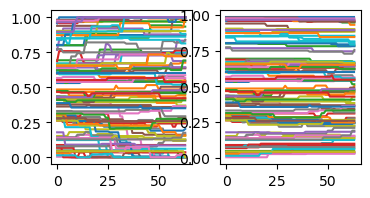

In [25]:
fig, axes = plt.subplots(ncols = 2,figsize = (4,2))
edges_iter = (edge for edge in edges)
axes[0].plot(compute_X_from_X0_params(X[0], edges_iter, mu_plus, mu_minus, is_backfire = True))
edges_iter = (edge for edge in edges)
axes[1].plot(compute_X_from_X0_params(X[0], edges_iter, mu_plus, mu_minus, is_backfire = False))
fig.show()

In [17]:
res_svinf = train_svi(X, edges, mu_plus, mu_minus, guide_family = "normal", rho = 32,
             n_steps = 10000, intermediate_steps = None, lr = 0.01,
             progress_bar = True)

100%|██████████| 10000/10000 [00:22<00:00, 443.32it/s, init loss: 459.1280, avg. loss [9501-10000]: 343.4629]


In [19]:
res_svinf

[{'param_mean': Array([0.09471975, 0.7915223 ], dtype=float32),
  'param_std': Array([0.00279232, 0.00530905], dtype=float32),
  'backfire_prob': Array([0.8929135], dtype=float32),
  'tot_time': 48.320146799087524,
  'n_simulations': None,
  'method': 'svinormal',
  'n_steps': 10000,
  'n_samples': None,
  'id': None}]

In [22]:
import inference_isbackfire

In [28]:
mu_plus, mu_minus, epsilon_plus, epsilon_minus

(0.13, 0.11, 0.25, 0.55)

In [26]:
inference_isbackfire.train_svi(X, edges, mu_plus, mu_minus, guide_family = "normal", rho = 32,
                               n_steps = 10000, intermediate_steps = None, lr = 0.01,
                               progress_bar = True)

100%|██████████| 10000/10000 [00:15<00:00, 628.68it/s, init loss: 1101.8994, avg. loss [9501-10000]: 99.9086]


[{'param_mean': Array([0.26283005, 0.5632258 ], dtype=float32),
  'param_std': Array([0.00476825, 0.00613809], dtype=float32),
  'backfire_prob': Array([0.10197362], dtype=float32),
  'tot_time': 22.41696524620056,
  'n_simulations': None,
  'method': 'svinormal',
  'n_steps': 10000,
  'n_samples': None,
  'id': None}]

In [20]:
res_svinf

[{'param_mean': Array([0.04688191, 0.65349424], dtype=float32),
  'param_std': Array([0.00483315, 0.0071182 ], dtype=float32),
  'backfire_prob': Array([0.00867099], dtype=float32),
  'tot_time': 7.964637756347656,
  'n_simulations': None,
  'method': 'svinormal',
  'n_steps': 10000,
  'n_samples': None,
  'id': None}]

In [15]:
res_mcmc = train_mcmc(X, edges, mu_plus, mu_minus, rho = 32,
             n_samples = 200, 
             progress_bar = True)

KeyboardInterrupt: 

In [364]:
res_abc = train_abc(X, edges, mu_plus, mu_minus, rho = 32, populations_budget = 200)

ABC.Population WARNING: The total population weight 5.930433211255859e-09 is close to zero, which can be numerically problematic
ABC.Population WARNING: The total population weight 5.930433211255859e-09 is close to zero, which can be numerically problematic
ABC.Population WARNING: The total population weight 4.074888047303059e-09 is close to zero, which can be numerically problematic
ABC.Population WARNING: The total population weight 4.074888047303059e-09 is close to zero, which can be numerically problematic
ABC.Population WARNING: The total population weight 2.2473703877249172e-09 is close to zero, which can be numerically problematic
ABC.Population WARNING: The total population weight 2.2473703877249172e-09 is close to zero, which can be numerically problematic
ABC.Population WARNING: The total population weight 1.0688589136367234e-09 is close to zero, which can be numerically problematic
ABC.Population WARNING: The total population weight 1.0688589136367234e-09 is close to zero, w

KeyboardInterrupt: 

In [359]:
res_svinf[0], res_mcmc[0], res_abc

({'param_mean': Array([0.09911286, 0.8379765 ], dtype=float32),
  'param_std': Array([0.0011964 , 0.00235555], dtype=float32),
  'backfire_prob': Array([0.9986557], dtype=float32),
  'tot_time': 23.563847541809082,
  'n_simulations': None,
  'method': 'sviNF',
  'n_steps': 5000,
  'n_samples': None,
  'id': None},
 {'param_mean': Array([0.1670443 , 0.76918197], dtype=float32),
  'param_std': Array([0.00850605, 0.01608652], dtype=float32),
  'backfire_prob': Array([0.00145417], dtype=float32),
  'tot_time': 7.912664413452148,
  'n_simulations': None,
  'method': 'mcmc',
  'n_steps': None,
  'n_samples': 200,
  'id': None},
 [])

In [69]:
N = 20
tot_times = []
for T in [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    print(T)
    X, edges = BC_update.simulate_trajectory(N = N, T = T, edge_per_t = edge_per_t,
                                         epsilon_plus = epsilon_plus, epsilon_minus = epsilon_minus,
                                         mu_plus = mu_plus, mu_minus = mu_minus, rho = rho)
    res_svinf = train_svi(X, edges, guide_family = "NF", rho = 32,
             n_steps = 10000, intermediate_steps = None, lr = 0.01,
             progress_bar = True)
    tot_times.append((T, res_svinf[0]["tot_time"]))
    


10


100%|██████████| 5000/5000 [00:04<00:00, 1116.67it/s, init loss: 65.9158, avg. loss [4751-5000]: 8.5953]


15


100%|██████████| 5000/5000 [00:06<00:00, 750.40it/s, init loss: 100.0989, avg. loss [4751-5000]: 18.8588] 


20


100%|██████████| 5000/5000 [00:11<00:00, 452.76it/s, init loss: 140.5759, avg. loss [4751-5000]: 21.1834] 


25


100%|██████████| 5000/5000 [00:14<00:00, 352.49it/s, init loss: 173.0278, avg. loss [4751-5000]: 28.1553] 


30


100%|██████████| 5000/5000 [00:16<00:00, 300.98it/s, init loss: 191.2382, avg. loss [4751-5000]: 35.6772]


35


100%|██████████| 5000/5000 [00:21<00:00, 227.52it/s, init loss: 147.4474, avg. loss [4751-5000]: 36.8972]


40


100%|██████████| 5000/5000 [00:25<00:00, 195.96it/s, init loss: 253.1107, avg. loss [4751-5000]: 38.9031]


45


100%|██████████| 5000/5000 [00:32<00:00, 153.56it/s, init loss: 186.9944, avg. loss [4751-5000]: 48.4145]


50


100%|██████████| 5000/5000 [00:39<00:00, 127.87it/s, init loss: 414.3330, avg. loss [4751-5000]: 61.7823]


55


100%|██████████| 5000/5000 [00:48<00:00, 103.34it/s, init loss: 355.9933, avg. loss [4751-5000]: 47.9289]


60


100%|██████████| 5000/5000 [01:02<00:00, 79.59it/s, init loss: 315.6882, avg. loss [4751-5000]: 32.2406] 


In [89]:
s = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140])
np.exp(s / 30) + 10

array([ 11.39561243,  11.94773404,  12.71828183,  13.79366789,
        15.29449005,  17.3890561 ,  20.3122585 ,  24.3919161 ,
        30.08553692,  38.03162489,  49.121284  ,  64.59815003,
        86.19785657, 116.3426754 ])

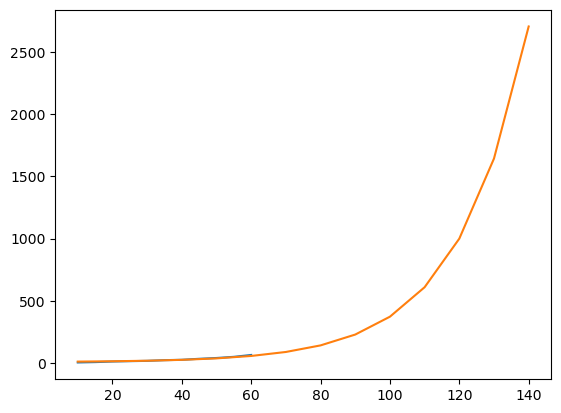

In [109]:
plt.plot(np.array(tot_times)[:,0], np.array(tot_times)[:,1])
plt.plot(s, np.exp((s + 18) / 20) + 8)

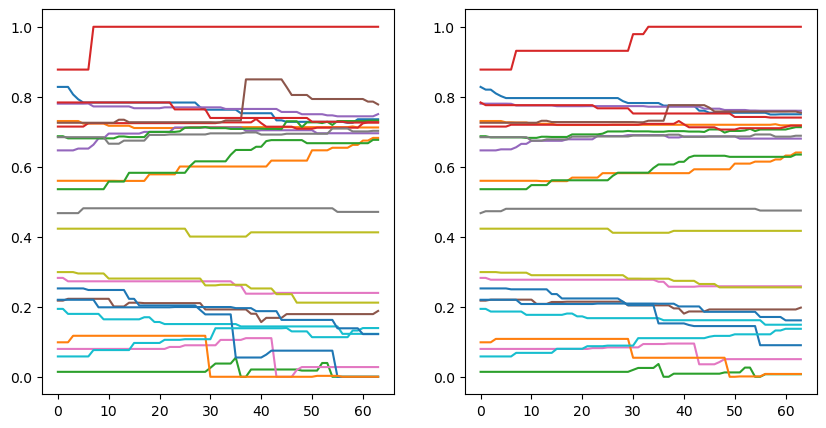

In [43]:
fig, axes = plt.subplots(ncols = 2, figsize = (10, 5))
X0 =jnp.array(X[0])
edges_iter = (edge_t for edge_t in edges)

X1 = compute_X_from_X0_params(X0, edges_iter, res_svinf[0]["param_mean"][0],res_svinf[0]["param_mean"][1],
                              # mu_plus, mu_minus,
                              res_svinf[0]["param_mean"][2], res_svinf[0]["param_mean"][3], 
                            # 0.01,0.2,
                              rho)
axes[0].plot(X)
axes[1].plot(X1)

fig.show()

In [56]:
import pandas as pd

In [69]:
#exps =[]
exps += [[[analyse_results(epsilon_plus, epsilon_minus, mu_plus, mu_minus, **res) for res in res_svinf][0][u] for u in ["epsilon_plus_error", "epsilon_minus_error", "mu_plus_error", "mu_minus_error", "tot_time"]] + [16, 1, "TraceGraph_ELBO"]]
pd.DataFrame(exps, columns = ["epsilon_plus_error", "epsilon_minus_error", "mu_plus_error", "mu_minus_error", "tot_time", "hidden_factors", "flows", "loss"])

,epsilon_plus_error,epsilon_minus_error,mu_plus_error,mu_minus_error,tot_time,hidden_factors,flows,loss
0,0.009659,0.069949,0.034028,0.016305,98.415250,16,1,TraceGraph_ELBO
1,0.011245,0.045665,0.025068,0.022351,90.856867,16,1,TraceGraph_ELBO
2,0.011245,0.045665,0.025068,0.022351,90.856867,16,1,TraceGraph_ELBO
3,0.011434,0.045747,0.025504,0.022913,71.087530,16,1,TraceGraph_ELBO
4,0.011434,0.045747,0.025504,0.022913,71.087530,16,1,TraceGraph_ELBO
5,0.011434,0.045747,0.025504,0.022913,71.087530,16,1,TraceGraph_ELBO
6,0.011434,0.045747,0.025504,0.022913,71.087530,16,1,TraceGraph_ELBO
7,0.011434,0.045747,0.025504,0.022913,93.569907,16,1,TraceGraph_ELBO
8,0.008386,0.000122,0.021417,0.023163,129.072983,16,1,TraceGraph_ELBO


In [31]:
exp = complete_experiment(N = 100, T = 20, edge_per_t = 5, rho = 32,
                    method = "sviNF",
                    epsilon_plus = None, epsilon_minus = None, mu_plus = None, mu_minus = None,
                    n_steps = 1000, n_samples = 100, populations_budget = 10, num_chains = 1,
                    intermediate_steps = None, intermediate_samples = None, warmup_samples = None, 
                    intermediate_populations = None, population_size = 200, progress_bar = True,
                    lr = 0.01, timeout = 25000, id = None, date = None, save_data = False
                        )

100%|██████████| 500/500 [01:48<00:00,  4.60it/s, init loss: 85.7430, avg. loss [476-500]: 13.4207]


In [32]:
exp

[{'id': None,
  'mse_params': 0.00040177247137762606,
  'mse_epsilon': 0.0002082852879539132,
  'mse_mu': 0.000595259596593678,
  'tot_time': 112.77577471733093,
  'n_steps': 500,
  'n_samples': None,
  'method': 'sviNF',
  'n_simulations': None,
  'epsilon_plus_error': 0.0010448545,
  'epsilon_minus_error': 0.020383298,
  'mu_plus_error': 0.034335658,
  'mu_minus_error': 0.0034032129,
  'epsilon_plus_mean': 0.2489551454782486,
  'epsilon_minus_mean': 0.7296167016029358,
  'mu_plus_mean': 0.05566434562206268,
  'mu_minus_mean': 0.05340321362018585,
  'epsilon_plus_std': 0.013606677763164043,
  'epsilon_minus_std': 0.024680383503437042,
  'mu_plus_std': 0.022995080798864365,
  'mu_minus_std': 0.021685583516955376,
  'epsilon_plus_real': 0.25,
  'epsilon_minus_real': 0.75,
  'mu_plus_real': 0.09,
  'mu_minus_real': 0.05,
  'pos_interactions_plus': 41.0,
  'pos_interactions_minus': 6.0,
  'tot_interactions': 95,
  'T': 20,
  'N': 100,
  'edge_per_t': 5,
  'var_X_end': 0.08939463170579415,

In [ ]:
if __name__ == '__main__':
    T, N = [int(sys.argv[k + 2]) for k in range(2)]
    method = sys.argv[4]
    date = sys.argv[5]

    rep = sys.argv[1]
    t0 = time()
    edge_per_t = 10

    id = f"{rep}_{N}_{T}"
    
    if not os.path.exists(f"../data/update_{date}"):
        try:
            os.mkdir(f"../data/update_{date}")
        except:
            None
    
    path = f"../data/update_{date}/estimation_T{T}_N{N}_rep{rep}_method{method}.pkl"

    print(f"++++++ update rep {rep} start {T} {N} {method} ++++++++")

    experiment = complete_experiment(N, T, edge_per_t, rho = 32,                    
                        n_steps=800, n_samples=200, 
                        method = method, populations_budget = 40, #intermediate_populations = 5,
                        population_size = 200, lr = 0.01,
                        id = id, date = date
                        )
    
    save_pickle(experiment, path)

    print(f">>>>>>>> update rep {rep} save {T} {N} {method} {round(time() - t0)}s <<<<<<<")
            


In [70]:
import inference_update

In [ ]:
res_inf = inference_update.train_svi(X, edges, guide_family = "NF", rho = 32,
             n_steps = 10000, intermediate_steps = None, lr = 0.01,
             progress_bar = True)
